In [ ]:


import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches


import torch.nn as nn
import os


In [ ]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 2
    elif obj.find('name').text == "mask_weared_incorrect":
        return 3
    return 1

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

       
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
       
        labels = torch.as_tensor(labels, dtype=torch.int64)
       
        img_id = torch.tensor([image_id])
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))


In [ ]:
labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        
        self.imgs = list(sorted(os.listdir("/content/gdrive/MyDrive/images")))
        self.labels = list(sorted(os.listdir("/content/gdrive/MyDrive/annotations")))

    def __getitem__(self, idx):
       
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/gdrive/MyDrive/images/", file_image)
        label_path = os.path.join("/content/gdrive/MyDrive/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
       
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=1, collate_fn=collate_fn)

In [ ]:
torch.cuda.is_available()

True

# Model

In [ ]:

def get_model():
    model123 = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
    model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False,num_classes = 4)
    model.backbone = model123.backbone
    model.head.classification_head.conv = model123.head.classification_head.conv
    model.head.regression_head = model123.head.regression_head
    return model


In [ ]:
model = get_model()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([1, 2, 1], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}]


# Train Model

In [ ]:

num_epochs = 50
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, nesterov = True,
                                momentum=0.9, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1, patience=3)

len_dataloader = len(data_loader)
losse = []
for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #scheduler.step(losses) 
        #print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    losse.append(epoch_loss/i)
    print(f'epoch: {epoch} losse: {epoch_loss/i}')


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch: 0 losse: 0.41013333201408386
epoch: 1 losse: 0.24355779588222504
epoch: 2 losse: 0.19092528522014618
epoch: 3 losse: 0.16958798468112946
epoch: 4 losse: 0.14380432665348053
epoch: 5 losse: 0.12548547983169556
epoch: 6 losse: 0.11336705833673477
epoch: 7 losse: 0.10384111851453781
epoch: 8 losse: 0.09558980166912079
epoch: 9 losse: 0.089262954890728
epoch: 10 losse: 0.08347634226083755
epoch: 11 losse: 0.07883915305137634
epoch: 12 losse: 0.07538127899169922
epoch: 13 losse: 0.07241246104240417
epoch: 14 losse: 0.06901458650827408
epoch: 15 losse: 0.0661807730793953
epoch: 16 losse: 0.06327234208583832
epoch: 17 losse: 0.06174815073609352
epoch: 18 losse: 0.059270523488521576
epoch: 19 losse: 0.05899796262383461
epoch: 20 losse: 0.05805107206106186
epoch: 21 losse: 0.055824995040893555
epoch: 22 losse: 0.05523865297436714
epoch: 23 losse: 0.05426093190908432
epoch: 24 losse: 0.05275735259056091
epoch: 25 losse: 0.05211319401860237
epoch: 26 losse: 0.05092581361532211
epoch: 27 lo

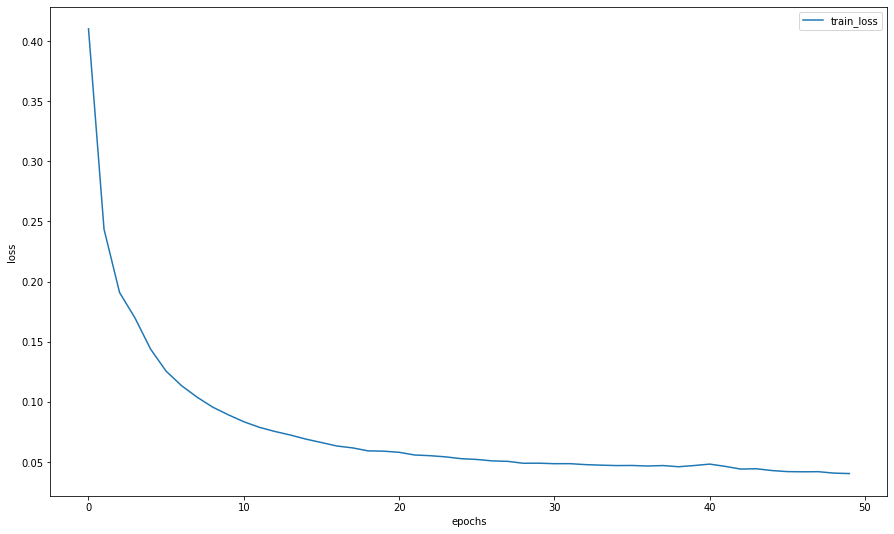

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(losse, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
i=0
for imgs, annotations in data_loader:
        i+=1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        if i == 35:
          break

In [ ]:
model.eval()
preds = model(imgs)


# Function to plot image

In [ ]:
def plot_image(img_tensor, annotation):
    
  fig,ax = plt.subplots(1, figsize=(8, 8))
  img = img_tensor.cpu().data
  ax.imshow(img.permute(1, 2, 0))

  dict_class = {1: 'no mask', 2: 'mask', 3: 'inc mask'}
  dict_color = {1: 'r', 2: 'g', 3: 'b'}
  spisok = [1, 2, 3]
  k = 0
  for box in annotation["boxes"]:
    xmin, ymin, xmax, ymax = box
    clas = 'None'
    for i in range(3):
      if int(annotation["labels"][k]) == spisok[i]:
        try:
          clas = dict_class[i+1] + ':' + str(round(float(annotation["scores"][k]),2))
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')
          ax.add_patch(rect)
        except:
          clas = dict_class[i+1]
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')
          ax.add_patch(rect)
    if clas != 'None':
      plt.text(xmax, ymax, f'{clas}', size=((xmax-xmin)/(((img.shape)[2])))*80, rotation=0.,
      ha="right", va="top",
      bbox=dict(boxstyle="square",
                ec=(1., 0.5, 0.5),
                fc=(1., 0.8, 0.8),
               )
      )
    k += 1
  plt.show()

In [ ]:
def iou(i, j):
    left = max(float(i[0]),float(j[0]))
    top = min(float(i[3]),float(j[3]))
    right = min(float(i[2]),float(j[2]))
    bottom = max(float(i[1]),float(j[1]))
    width = right - left
    height = top - bottom
    if width < 0 or height < 0:
      result = 0
    else:
      result = width * height
    area_target = abs(j[2] - j[0]) * abs(j[3] - j[1])
    area_pred = abs(i[2] - i[0]) * abs(i[3] - i[1])
    total_area = area_target + area_pred - result
    iou = result/total_area
    return(iou)

In [ ]:
iou(preds[0]['boxes'][0], preds[0]['boxes'][4])

tensor(0., device='cuda:0', grad_fn=<MulBackward0>)

In [ ]:
def choose(preds_old, iou):
  new_preds = {'boxes': [],'labels': [],'scores': []}
  preds = {'boxes': [],'labels': [],'scores': []}
  for i in range(len(preds_old['boxes'])):
    if preds_old['scores'][i] > 0.2:
      preds['boxes'].append(list(int(box) for box in preds_old['boxes'][i]))
      preds['labels'].append(int(preds_old['labels'][i]))
      preds['scores'].append(float(preds_old['scores'][i]))
  for i in range(len(preds['boxes'])):
    max_probability = preds['scores'][i]
    ind = i
    for j in range(len(preds['boxes'])):
      if iou(preds['boxes'][i], preds['boxes'][j]) > 0.2 and preds['scores'][j] > max_probability:
        max_probability = preds['scores'][j]
        ind = j
      else:
        ind = ind
    if list(int(box) for box in preds['boxes'][ind]) not in new_preds['boxes']:
      new_preds['boxes'].append(list(int(box) for box in preds['boxes'][ind]))
      new_preds['labels'].append(int(preds['labels'][ind]))
      new_preds['scores'].append(float(preds['scores'][ind]))
  return new_preds


Prediction


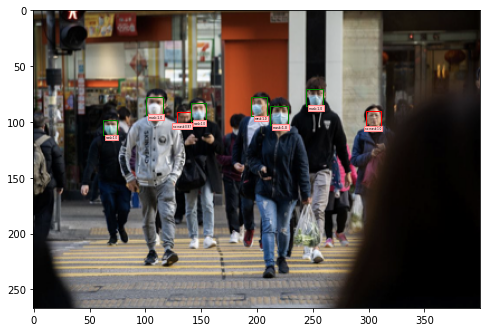

Target


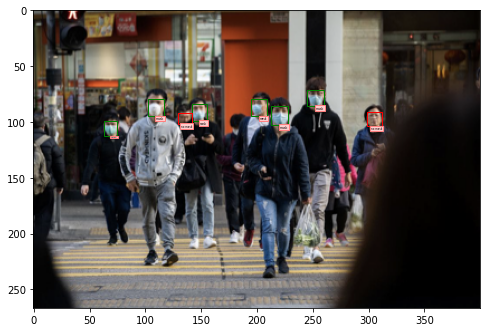

In [ ]:
print("Prediction")
plot_image(imgs[0], choose(preds[0], iou))
print("Target")
plot_image(imgs[0], annotations[0])


# Custom image downoload


In [ ]:
def custom_image(img_tensor, annotation):
    
  fig,ax = plt.subplots(1, figsize=(18, 18))
  img = img_tensor.cpu().data
  ax.imshow(img.permute(1, 2, 0))

  dict_class = {1: 'no mask', 2: 'mask', 3: 'inc mask'}
  dict_color = {1: 'r', 2: 'g', 3: 'b'}
  spisok = [1, 2, 3]
  k = 0
  for box in annotation["boxes"]:
    xmin, ymin, xmax, ymax = box
    clas = 'None'
    for i in range(3):
      if int(annotation["labels"][k]) == spisok[i]:
        try:
          clas = dict_class[i+1] + ':' + str(round(float(annotation["scores"][k]),2))
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')
          ax.add_patch(rect)
        except:
          clas = dict_class[i+1]
          rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=dict_color[i+1],facecolor='none')
          ax.add_patch(rect)
    if clas != 'None':
      plt.text(xmax, ymax, f'{clas}', size=((xmax-xmin)/(((img.shape)[2])))*80, rotation=0.,
      ha="right", va="top",
      bbox=dict(boxstyle="square",
                ec=(1., 0.5, 0.5),
                fc=(1., 0.8, 0.8),
               )
      )
    k += 1
  plt.show()

In [ ]:
class MaskDataset_real_test(object):
    def __init__(self, transforms, filename):
        self.transforms = transforms
        self.filename = filename

    def __getitem__(self, idx):
        img_path = os.path.join("/content/gdrive/MyDrive/test_images/", self.filename)
        img = Image.open(img_path).convert("RGB")
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset_test = MaskDataset_real_test(data_transform,  'р.png' )
img_t = [dataset_test[0]]
img_t = list(img.to(device) for img in img_t)
model.eval()
preds = model(img_t)

Prediction


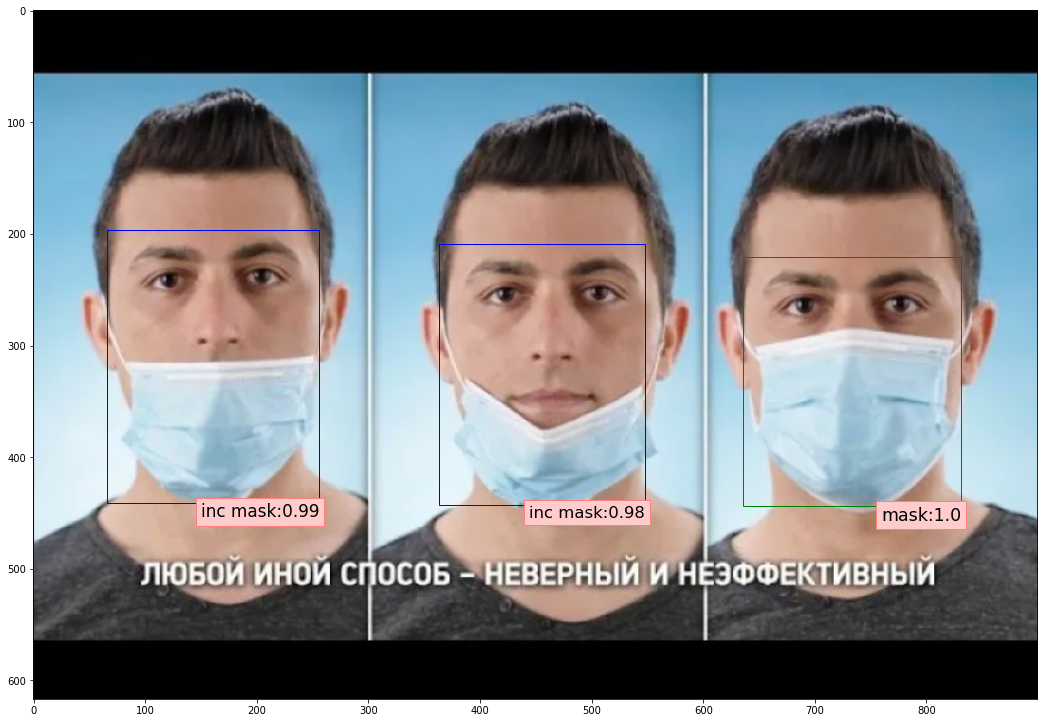

In [ ]:

print("Prediction")
custom_image(img_t[0], choose(preds[0], iou))


# Save Model

In [ ]:
torch.save(model.state_dict(),'model1.pt')

# Load Model

In [ ]:

model2 = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=False,num_classes = 4)


In [ ]:
model2.load_state_dict(torch.load('model1.pt'))
model2.eval()
model2.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

In [ ]:
pred2 = model2(imgs)

Predict with loaded model


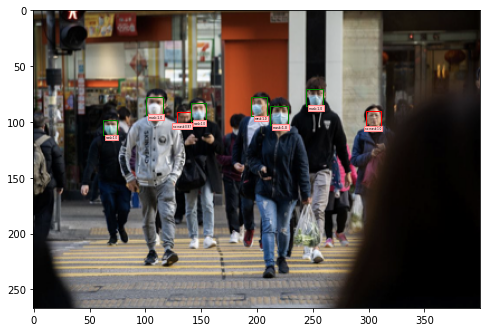

In [ ]:
print("Predict with loaded model")
plot_image(imgs[0], choose(pred2[0], iou))